## SARIMA on BYOML with the `custom` framework
In this notebook we will demonstrate how you can use a statistical  model like SARIMA, upload it to byoml and afterwards perform a (forecasting) prediction with the deployed model.

This notebook uses the `custom` framework, supported by BYOML since version `1.4.0`, to use the [statsmodels](https://www.statsmodels.org) implementation of [SARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html?highlight=sarima#statsmodels.tsa.statespace.sarimax.SARIMAX).

Specifying additional byoml requirements is supported in the Python SDK from version `0.4.0` onwards.

We use WPI data from [stata](https://www.stata-press.com/data/). See also Example 5 in [this](https://www.stata.com/manuals/tsforecastestimates.pdf) stata manual.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import httpx
import statsmodels.api as sm
from http import HTTPStatus

from io import BytesIO

In [5]:
wpi1 = httpx.get('https://www.stata-press.com/data/r17/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
# set quarter index frequency: not necessary, but suppresses warnings
data.index.freq='QS'
data = data[['wpi']]

<AxesSubplot:xlabel='t'>

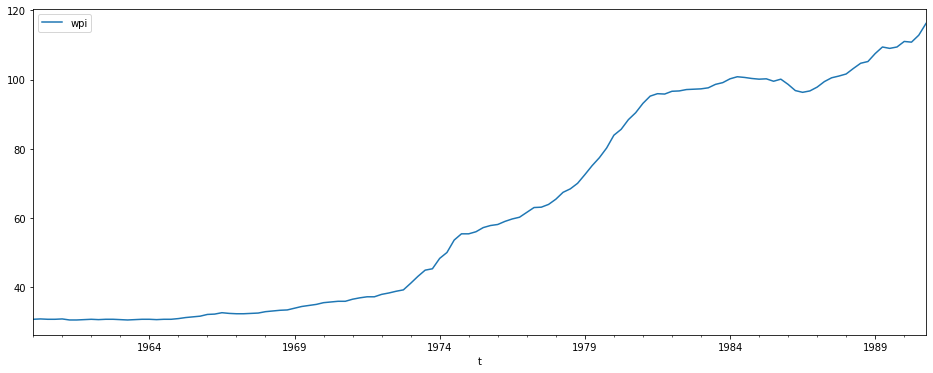

In [6]:
data.plot(figsize = (16, 6))

#### training data

In [7]:
train_size = int(len(data.index) * 0.9)
df_train = data.iloc[:train_size]
df_train.head()

,wpi
t,
1960-01-01,30.700001
1960-04-01,30.799999
1960-07-01,30.700001
1960-10-01,30.700001
1961-01-01,30.799999


#### model fitting

This sarima model uses hyperparameters that set first order (`1,1,1`) modeling on the autoregression (AR), differencing (I), and moving average (MA) parts, both for the 1-step prediction (`order`) as for the seasonal (S) component (`seasonal_order`). 

We set a seasonality of `4` for a yearly season on quarterly data.

We do not use the _exogenous_ (X) component supported by this model.

First we will create a local model, later we can compare results of the served model to this local model.

In [8]:
model = sm.tsa.SARIMAX(
    df_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 4),
)
fitted_model = model.fit(maxiter=250, disp=10)
fitted_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09970D+00    |proj g|=  2.19501D-01

At iterate   10    f=  9.82291D-01    |proj g|=  2.09950D-02

At iterate   20    f=  9.79928D-01    |proj g|=  2.43645D-03

At iterate   30    f=  9.79777D-01    |proj g|=  1.22567D-03

At iterate   40    f=  9.79775D-01    |proj g|=  9.66807D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     68      1     0     0   9.666D-04   9.798D-01
  F =  0.97977489325762179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               wpi   No. Observations:                  111
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -108.755
Date:                           Tue, 02 Aug 2022   AIC                            227.510
Time:                                   17:48:04   BIC                            240.827
Sample:                               01-01-1960   HQIC                           232.908
                                    - 07-01-1987                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8560      0.071     11.987      0.000       0.716       0.996
ma.L1         -0.3205      0.127     -2.529      0.011      -0.569      -0.072
ar.S.L4        0.1435      0.127      1.133      0.257      -0.105       0.392
ma.S.L4       -0.9985      3.715     -0.269      0.788      -8.280       6.283
sigma2         0.4091      1.514      0.270      0.787      -2.559       3.377
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.41
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              21.40   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

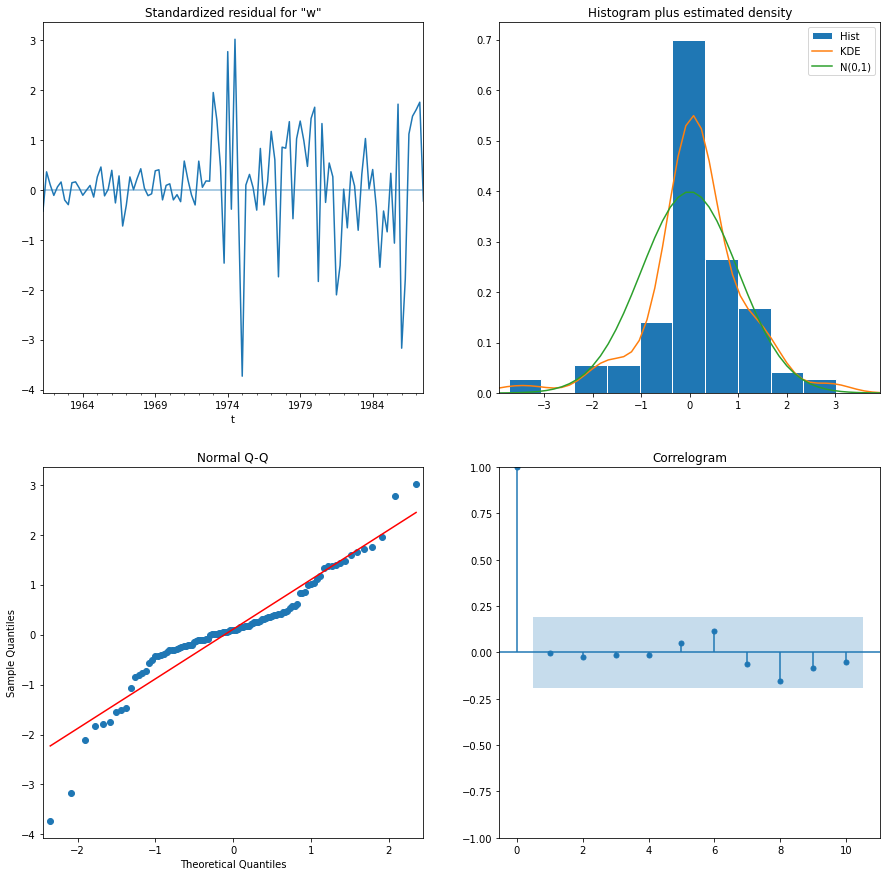

In [9]:
diag_plot = fitted_model.plot_diagnostics(figsize=(15, 15))


#### one-step forecast (in-band)
The following cell performs a one-step ahead forecast of the 30 latest data points.

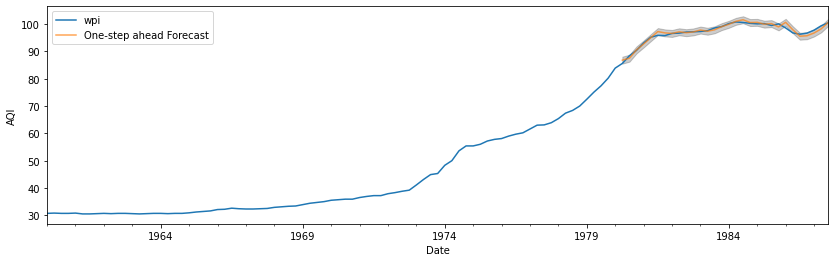

In [10]:
prediction = fitted_model.get_prediction(start=-30)
pred_ci = prediction.conf_int(alpha=0.05)
pred_mean = prediction.predicted_mean
ax = df_train.plot(label='observed')
pred_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1], color='k', alpha=.2
)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

#### forecast (future prediction)

The `forecast` method of the fitted model will give you predictions in the future.

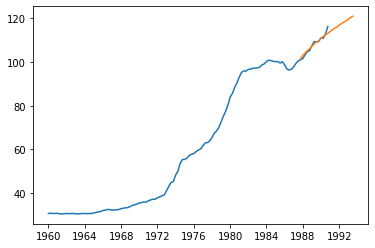

In [11]:
forecast_window = 24
forecast = fitted_model.forecast(steps=forecast_window)
plt.plot(data.index, data.wpi)
plt.plot(forecast.index, forecast.values)

The `get_forecast` method also gives confidence intervals.

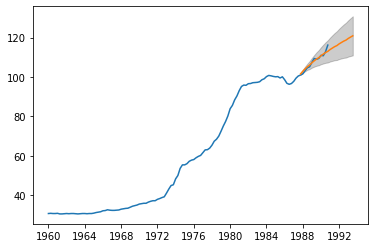

In [12]:
forecast = fitted_model.get_forecast(steps=forecast_window)
forecast_mean = forecast.predicted_mean
# using a 50% confidence interval:
forecast_ci = forecast.conf_int(alpha=0.5)
plt.plot(data.index, data.wpi)
plt.plot(forecast_mean.index, forecast_mean.values)
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1], 
    color='k', alpha=.2
)
plt.show()

Let's create a custom BYOML model wrapper that we can fit and deploy to BYOML.
We set up the waylay client. 

In [22]:
from waylay import WaylayClient, RestResponseError, __version__
waylay = WaylayClient.from_profile('io')

# diagnostics
display(__version__)
display(waylay.byoml.root_url)
display(waylay.byoml.about.health())

'v0.4.0'

'https://byoml-io.waylay.io'

'OK: byoml-1.5.0'

## data conversion
Our model uses use pandas timeseries, but when deployed, the byoml runtime hands over numpy arrays to the `predict` method.

The following functions convert from and to numpy arrays of shape ( nr_of_observations, 2). The inner records are a (timestamp, value) with timestamps encoded as epoch milliseconds, e.g. as produced by the `executeQuery`(http://docs-io.waylay.io/#/sensors/executeQuery) plug with the `removeTimestamps=false` option.

A typical request that would be sent to the deployed byoml function as (`Content-Type: application/json`)
```http
POST /models/sarima-model/predict 
{
  "instances" : [
     [-315619200000.0, 30.700000762939453],
     [-307756800000.0, 30.799999237060547],
     [-299894400000.0, 30.700000762939453],
     ...
  ]
}
```


In [11]:
def convert_to_pandas(data, feature_columns=['value'], index_freq='QS'):
    """convert data with as first feature epoch-milliseconds."""
    expected_row_size = 1 + len(feature_columns)
    if isinstance(data, list):
        data = np.array(data)
    if isinstance(data, np.ndarray):
        (instance_count, row_count) = data.shape
        if row_count == expected_row_size:
            timestamps = data[:,0] 
            values = data[:, 1:]              
        elif instance_count == expected_row_size:
            # support both column and row-oriented array shapes
            timestamps = data[0,:]
            values = data[1:, :].transpose()
        else:
            raise ValueError(f"This model requires a timestamp and '{feature_columns}' rows as input")
        if len(timestamps) and isinstance(timestamps[0], np.number):
            # millisecond epoch is standard for waylay
            timestamp_index = pd.to_datetime(timestamps, unit='ms')
        else:
            # this will parse ISO8601 timestamp strings
            timestamp_index = pd.to_datetime(timestamps)
        if index_freq:
            timestamp_index.freq=index_freq
        data = pd.DataFrame(values, index=timestamp_index, columns=feature_columns)

    if not isinstance(data, pd.DataFrame):
        raise ValueError('This model requires an input that can be converted to a dataframe.')
        
    return data

def convert_to_numpy(series_or_df):
    # convert dataframe to an array of (timestamp_millis, values... ) tuples
    
    # pd.Timestamp has internal nano representation
    timestamps = series_or_df.index.view(np.int64) / 1000000
    if isinstance(series_or_df, pd.DataFrame):
        df = series_or_df
        series = [ df[c].values for c in df.columns ]
        return np.array([timestamps, *series]).transpose()
    else:
        series = series_or_df.values
        return np.array([timestamps, series]).transpose()


Check these functions with a roundtrip on the first lines of our data set:

In [12]:
json_data = convert_to_numpy(data.head()).tolist()
display(json_data)
pandas_data = convert_to_pandas(json_data)
display(pandas_data)

[[-315619200000.0, 30.700000762939453],
 [-307756800000.0, 30.799999237060547],
 [-299894400000.0, 30.700000762939453],
 [-291945600000.0, 30.700000762939453],
 [-283996800000.0, 30.799999237060547]]

,value
1960-01-01,30.700001
1960-04-01,30.799999
1960-07-01,30.700001
1960-10-01,30.700001
1961-01-01,30.799999


## Byoml Model wrapper

We now create a helper class around the SARIMA model and test the local predict method.
* it has a `fit` method to train the model before we upload it. The fitted state is stored in an object attribute,
  so that it will be available when running the model on the BYOML runtime.
* it has a `predict` method that will be used in the deployed model to restore the fitted model on an array of historical data, and perform a prediction after this input.
* the `window` attribute defines the forecasting window used when calling `predict`.
* it uses the hooks `map_input` and `map_output` to convert input and output from and the plain json-serializable data structures that the BYOML runtime receives and sends. The byoml runtime will recognize these hooks by their names.

In [13]:
class SARIMAXForecaster:
    def __init__(self, window=24):
        self.window = window
        self.fitted_params = None

    def map_input(self, request):
        """Convert the json-data request payload to the input for `predict`."""
        return convert_to_pandas(request['instances'])
    
    def map_output(self, request, result):
        """Convert the output of `predict` to a json-data response payload."""
        return { 'predictions': convert_to_numpy(result).tolist() }

    def create_model(self, data):
        return sm.tsa.SARIMAX(
            data,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 4),
            enforce_stationarity=False
        )
    
    def fit(self, data, **fit_args):
        fitted_model = self.create_model(data).fit(**fit_args)
        self.fitted_params = fitted_model.params
        return fitted_model
    
    def get_fitted_model(self, data):
        model = self.create_model(data)
        if self.fitted_params is None:
            raise ValueError('Model has not been fitted')
        return model.smooth(self.fitted_params)
        
    def predict(self, data):
        fitted_model = self.get_fitted_model(data)
        return fitted_model.forecast(steps=self.window)


In [14]:
# fit and test the wrapped model
upload_model = SARIMAXForecaster()
upload_model.fit(df_train, disp=0)
preds_df = upload_model.predict(df_train)
preds_df.head()

1987-10-01    101.422581
1988-01-01    102.621916
1988-04-01    103.612149
1988-07-01    104.563442
1988-10-01    105.332459
Freq: QS-JAN, Name: predicted_mean, dtype: float64

In [15]:
# test including the data conversion:
## this would be the data sent to byoml
json_data_req = { 'instances': convert_to_numpy(df_train).tolist() }

## these are the steps the byoml service will invoke on the model wrapper
mapped_input = upload_model.map_input(json_data_req)
preds_df = upload_model.predict(mapped_input)
mapped_output = upload_model.map_output(json_data_req, preds_df)

## this would be the response data sent back
display(mapped_output)

{'predictions': [[560044800000.0, 101.42258076623573],
  [567993600000.0, 102.6219164227255],
  [575856000000.0, 103.61214878201058],
  [583718400000.0, 104.56344216614647],
  [591667200000.0, 105.33245944963153],
  [599616000000.0, 106.39760050442275],
  [607392000000.0, 107.2705635525155],
  [615254400000.0, 108.11937977412252],
  [623203200000.0, 108.79884562308324],
  [631152000000.0, 109.78573064594606],
  [638928000000.0, 110.59030834023858],
  [646790400000.0, 111.37936486666369],
  [654739200000.0, 112.00660869775298],
  [662688000000.0, 112.94785862923429],
  [670464000000.0, 113.71255732898989],
  [678326400000.0, 114.46676492321981],
  [686275200000.0, 115.06355542695606],
  [694224000000.0, 115.97819320453611],
  [702086400000.0, 116.71963642461775],
  [709948800000.0, 117.4535218255794],
  [717897600000.0, 118.03255343786195],
  [725846400000.0, 118.93167230852578],
  [733622400000.0, 119.6595540699712],
  [741484800000.0, 120.3815885615012]]}

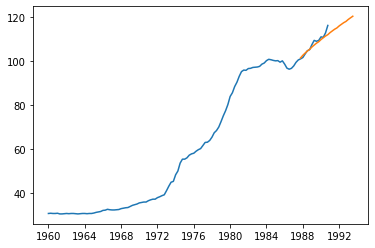

In [16]:
plt.plot(
    data.index,
    data.wpi
)
plt.plot(preds_df.index, preds_df.values)

Define the model name for this notebook, delete any model with that name that would already exist. 

In [17]:
MODEL_NAME = 'sarima-model'

try:
    resp = waylay.byoml.model.remove(MODEL_NAME)
    display(resp)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'No model with name sarima-model'; DELETE 'http://localhost:9050/models/sarima-model')"

To deploy our model on BYOML, we will need to save the model using the `dill` library and upload it together with a `requirements` argument that includes the `statsmodels` library.

In [18]:
# check wether your deployment supports the `custom` framework
waylay.byoml.framework.get('custom')

{'default_runtime': {'framework': 'custom',
  'framework_version': '1.0',
  'name': 'byoml-custom-1.0',
  'python_version': '3.7'},
 'framework': 'custom',
 'versions': ['1.0']}

In [23]:
try:
    waylay.byoml.model.upload(
        MODEL_NAME,
        upload_model,
        framework='custom',
        description='SARIMA model example',
        requirements='statsmodels==0.13',
    )
except RestResponseError as e:
    assert e.response.status_code == HTTPStatus.BAD_GATEWAY
    print('KNOWN issue: ignoring a BAD_GATEWAY error upon model deployment')

LocalProtocolError: Too little data for declared Content-Length

Listing the models won't affect the deployment status of the model

In [20]:
waylay.byoml.model.list(params={"name":MODEL_NAME})

[{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'createdOn': '2021-10-15T14:55:38.149000+00:00',
  'description': 'SARIMA model example',
  'framework': 'custom',
  'framework_version': '1.0',
  'metadata': {'description': 'SARIMA model example'},
  'name': 'sarima-model',
  'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'updatedOn': '2021-10-15T14:56:39.505000+00:00',
  'version': '1'}]

Getting the model, will check that the model is ready to serve ...

In [22]:
waylay.byoml.model.get(MODEL_NAME)

{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2021-10-14T08:57:27.475000+00:00',
 'description': 'SARIMA model example',
 'framework': 'custom',
 'framework_version': '1.0',
 'metadata': {'description': 'SARIMA model example'},
 'name': 'sarima-model',
 'ready': False,
 'supported_endpoints': [],
 'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'updatedOn': '2021-10-14T08:57:27.487000+00:00',
 'version': '1'}

When requesting predictions, the python SDK will retry until the model is ready to serve (see [retry handling](http://docs-io.waylay.io/#/api/sdk/python?id=retry-handling))

In [23]:
predictions = waylay.byoml.model.predict(MODEL_NAME, convert_to_numpy(df_train))
predictions_df = convert_to_pandas(predictions)
predictions_df.head()

,value
1987-10-01,101.422581
1988-01-01,102.621916
1988-04-01,103.612149
1988-07-01,104.563442
1988-10-01,105.332459


In [ ]:
plt.plot(
    data.index,
    data.wpi
)
plt.plot(
    predictions_df.index,
    predictions_df.values
)

In [21]:
# remove the deployed model
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model sarima-model: all versions deleted',
 'name': 'sarima-model',
 'versions': ['0.0.1']}

##  parameterization: confidence intervals


Let's adapt the model to support confidence intervals instead of mean predictions. This also shows how you can pass custom parameters to you model inference.

In [49]:
class SARIMAXConfidenceForecaster:
    def __init__(self, default_window=24, default_alpha=0.05):
        self.default_window = default_window
        self.fitted_params = None
        self.default_alpha = default_alpha

    def map_input(self, request):
        """Convert the json-data request payload to the input for `predict`."""
        # allow the user to specify an alternate alpha for the confidence intervals
        instances = convert_to_pandas(request['instances'])
        alpha = request.get('alpha', self.default_alpha)
        window = request.get('window', self.default_window)
        return (instances, window, alpha)

    def map_output(self, request, result):
        """Convert the output of `predict` to a json-data response payload."""
        return { 'predictions': convert_to_numpy(result).tolist() }

    def create_model(self, data):
        return sm.tsa.SARIMAX(
            data,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 4),
            enforce_stationarity=False
        )
    
    def fit(self, data, **fit_args):
        fitted_model = self.create_model(data).fit(**fit_args)
        self.fitted_params = fitted_model.params
        return fitted_model
    
    def get_fitted_model(self, data):
        model = self.create_model(data)
        if self.fitted_params is None:
            raise ValueError('Model has not been fitted')
        return model.smooth(self.fitted_params)
        
    def predict(self, data_window_and_alpha):
        data, window, alpha = data_window_and_alpha
        fitted_model = self.get_fitted_model(data)
        forecast = fitted_model.get_forecast(steps=window)
        return forecast.conf_int(alpha=alpha)


In [50]:
CI_MODEL_NAME = 'sarima-model-ci'
try:
    resp = waylay.byoml.model.remove(CI_MODEL_NAME)
    display(resp)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'Model does not exist'; DELETE 'https://byoml-staging.waylay.io/models/sarima-model-ci')"

In [51]:
upload_model_ci = SARIMAXConfidenceForecaster()
upload_model_ci.fit(df_train, disp=0)

# test locally
upload_model_ci.predict(( df_train, 24, 0.1)).head()

,lower wpi,upper wpi
1987-10-01,100.319864,102.525297
1988-01-01,100.597097,104.646736
1988-04-01,100.608369,106.615928
1988-07-01,100.542214,108.584671
1988-10-01,100.248873,110.416046


In [74]:
# upload model
try:
    waylay.byoml.model.upload(
        CI_MODEL_NAME,
        upload_model_ci,
        framework='custom',
        description='SARIMA model example with confidence intervals',
        requirements='statsmodels==0.13',
    )
except RestResponseError as e:
    assert e.response.status_code == HTTPStatus.BAD_GATEWAY
    print('KNOWN issue: ignoring a BAD_GATEWAY error upon model deployment')

AttributeError: 'NoneType' object has no attribute 'status_code'

In [71]:
waylay.byoml.model.get(CI_MODEL_NAME)

{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2021-10-15T14:49:00.128000+00:00',
 'description': 'SARIMA model example with confidence intervals',
 'framework': 'custom',
 'framework_version': '1.0',
 'metadata': {'description': 'SARIMA model example with confidence intervals'},
 'name': 'sarima-model-ci',
 'ready': True,
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'updatedOn': '2021-10-15T14:50:44.631000+00:00',
 'version': '1'}

In [69]:
predictions = waylay.byoml.model.predict(CI_MODEL_NAME, convert_to_numpy(df_train).tolist())
predictions_df = convert_to_pandas(predictions, ['ci_low', 'ci_high'])
predictions_df.head()

,ci_low,ci_high
1987-10-01,100.108613,102.736549
1988-01-01,100.209195,105.034638
1988-04-01,100.032925,107.191373
1988-07-01,99.771853,109.355031
1988-10-01,99.274993,111.389926


In [62]:
predictions = waylay.byoml.model.predict(
    CI_MODEL_NAME, convert_to_numpy(df_train).tolist(),
    body = {"alpha": 0.5}
)
predictions_df = convert_to_pandas(predictions, ['ci_low', 'ci_high'])
predictions_df.head()

ByomlActionError: ByomlActionError(404: 'No model 'sarima-model-ci''; POST 'http://localhost:9050/models/sarima-model-ci/predict')

ByomlActionError: ByomlActionError(404: 'No model 'sarima-model-ci''; POST 'http://localhost:9050/models/sarima-model-ci/predict')

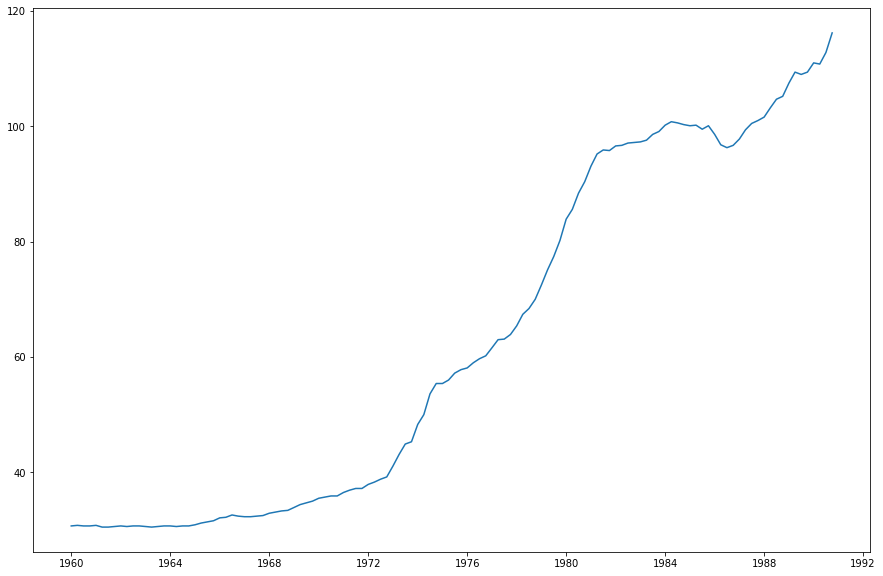

In [73]:
fig, ax= plt.subplots(figsize=(15,10))
ax.plot(
    data.index,
    data.wpi,
    label='wpi'
)
input_data = convert_to_numpy(df_train[:-36]).tolist()
for alpha_exp in range(0,8):
    alpha = 0.5 ** alpha_exp
    predictions = waylay.byoml.model.predict(
        CI_MODEL_NAME, input_data,
        body = {'alpha': alpha ** 1.0, 'window': 40}
    )
    predictions_df = convert_to_pandas(predictions, ['ci_low', 'ci_high'])
    ax.fill_between(
    predictions_df.index,
        predictions_df['ci_low'],
        predictions_df['ci_high'], 
        color='red', alpha=alpha ** 0.9,
        label=f'confidence {(1-alpha) * 100:5.2f}%'
    )
ax.legend()

In [72]:
waylay.byoml.model.remove(CI_MODEL_NAME)

{'message': 'Model sarima-model-ci: all versions deleted',
 'name': 'sarima-model-ci',
 'versions': ['0.0.1']}